<a href="https://colab.research.google.com/github/221FA04030/Distracted-Driver-Behaviour/blob/main/vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install specific versions of the libraries in Colab
!pip install numpy==1.26.4 scipy==1.15.2 scikit-learn==1.6.1 lightgbm==4.6.0 catboost


In [ ]:
!apt-get install -y cmake


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
import numpy as np
import scipy
import sklearn
import catboost
import lightgbm

# Print versions to ensure they are correct
print("NumPy version:", np.__version__)
print("SciPy version:", scipy.__version__)
print("Scikit-Learn version:", sklearn.__version__)
print("CatBoost version:", catboost.__version__)
print("LightGBM version:", lightgbm.__version__)


NumPy version: 1.26.4
SciPy version: 1.15.2
Scikit-Learn version: 1.6.1
CatBoost version: 1.2.7
LightGBM version: 4.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
zip_path = "/content/drive/My Drive/archive.zip"

if os.path.exists(zip_path):
    print("✅ Zip file found! Proceeding with extraction.")
else:
    print("❌ Zip file NOT found! Check the path.")

✅ Zip file found! Proceeding with extraction.


In [ ]:
import zipfile

extract_path = "/content/dataset"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully!")
print("Extracted files:", os.listdir(extract_path))

✅ Dataset extracted successfully!
Extracted files: ['imgs', 'driver_imgs_list.csv', 'sample_submission.csv']


In [ ]:
import os
import pandas as pd

# Define extract_path (Make sure this variable is set correctly)
extract_path = "/content/dataset"  # Change this to your actual path

# Load the CSV file
csv_path = os.path.join(extract_path, "driver_imgs_list.csv")
df = pd.read_csv(csv_path)

# Display first few rows
print(df.head())

  subject classname            img
0    p012        c0  img_10206.jpg
1    p012        c0  img_27079.jpg
2    p012        c0  img_50749.jpg
3    p012        c0  img_97089.jpg
4    p012        c0  img_37741.jpg


In [ ]:
# Import required libraries
import os
import zipfile
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define dataset path in Google Drive
zip_path = "/content/drive/My Drive/archive.zip"  # Update if needed
extract_path = "/content/dataset"

# Step 3: Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully!")

# Step 4: Define paths
train_dir = os.path.join(extract_path, "imgs", "train")
csv_path = os.path.join(extract_path, "driver_imgs_list.csv")

# Step 5: Load CSV File (Check driver image labels)
df = pd.read_csv(csv_path)
print(df.head())

# Step 6: Use ImageDataGenerator to Load Images in Batches (No RAM Overload)
IMG_SIZE = (224, 224)  # Resize images
BATCH_SIZE = 32  # Load images in small batches

# Data Generator for Training and Validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # 80% training
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # 20% validation
)

print("✅ Data Generators Ready!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset extracted successfully!
  subject classname            img
0    p012        c0  img_10206.jpg
1    p012        c0  img_27079.jpg
2    p012        c0  img_50749.jpg
3    p012        c0  img_97089.jpg
4    p012        c0  img_37741.jpg
Found 13975 images belonging to 10 classes.
Found 3487 images belonging to 10 classes.
✅ Data Generators Ready!


In [ ]:
!ls -R "/content/dataset"

/content/dataset:
driver_imgs_list.csv  imgs  sample_submission.csv

/content/dataset/imgs:
test  train

/content/dataset/imgs/test:
img_100015.jpg	img_2388.jpg   img_39046.jpg  img_5356.jpg   img_68961.jpg  img_84735.jpg
img_100027.jpg	img_23911.jpg  img_39052.jpg  img_53570.jpg  img_68974.jpg  img_84745.jpg
img_100046.jpg	img_23917.jpg  img_39059.jpg  img_53609.jpg  img_68989.jpg  img_84752.jpg
img_100057.jpg	img_23932.jpg  img_3906.jpg   img_53621.jpg  img_6899.jpg   img_84776.jpg
img_100061.jpg	img_23966.jpg  img_39097.jpg  img_5362.jpg   img_69003.jpg  img_84810.jpg
img_100108.jpg	img_2398.jpg   img_39099.jpg  img_53650.jpg  img_69034.jpg  img_8482.jpg
img_100113.jpg	img_23996.jpg  img_39110.jpg  img_53664.jpg  img_69053.jpg  img_84843.jpg
img_100116.jpg	img_24009.jpg  img_39113.jpg  img_53667.jpg  img_69059.jpg  img_84899.jpg
img_10012.jpg	img_24010.jpg  img_39114.jpg  img_53697.jpg  img_69061.jpg  img_84934.jpg
img_100168.jpg	img_24017.jpg  img_39118.jpg  img_53713.jpg  img_6908

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define paths and create data generators
extract_path = "/content/dataset"
train_dir = os.path.join(extract_path, "imgs", "train")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Define VGG19 feature extractor
def get_feature_extractor():
    base_model = VGG19(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))
    return model

# Extract features from dataset
def extract_features(model, generator):
    features = []
    labels = []
    total_batches = len(generator)

    for i, (batch_images, batch_labels) in enumerate(generator):
        batch_features = model.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)

        print(f"Processed batch {i+1}/{total_batches}", end="\r")

        if i >= total_batches - 1:
            break

    return np.vstack(features), np.vstack(labels)

# Extract features using VGG19
vgg19_model = get_feature_extractor()
X_train_vgg19, y_train_vgg19 = extract_features(vgg19_model, train_generator)
X_val_vgg19, y_val_vgg19 = extract_features(vgg19_model, val_generator)

print(f"✅ VGG19 Feature Extraction Complete!")
print(f"Feature Shape (Train): {X_train_vgg19.shape}, Labels Shape: {y_train_vgg19.shape}")
print(f"Feature Shape (Val): {X_val_vgg19.shape}, Labels Shape: {y_val_vgg19.shape}")


Found 13975 images belonging to 10 classes.
Found 3487 images belonging to 10 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━

In [ ]:
def train_xgboost(X_train, y_train, X_val, y_val):
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    val_dmatrix = xgb.DMatrix(X_val, label=y_val)

    xgb_model = xgb.train(
        xgb_params, train_dmatrix, num_boost_round=50,
        evals=[(train_dmatrix, 'train'), (val_dmatrix, 'val')],
        early_stopping_rounds=5, verbose_eval=5
    )
    xgb_preds = xgb_model.predict(val_dmatrix)
    return xgb_model, xgb_preds

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

def train_adaboost(X_train, y_train, X_val, y_val):
    # ✅ Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # ✅ Dimensionality Reduction (PCA)
    pca = PCA(n_components=100)  # Adjusted number of components (keeps more variance)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)

    # ✅ Apply SMOTE for handling class imbalance (if any)
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

    # ✅ AdaBoost Model with Hyperparameter Tuning using GridSearchCV
    adaboost_model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),  # Depth reduced to balance speed and accuracy
        random_state=42
    )

    # Define an optimized hyperparameter grid
    param_grid = {
        'n_estimators': [100, 150, 200],   # Reduced estimators for speed but sufficient for accuracy
        'learning_rate': [0.1, 0.5],       # Tuning learning rates for optimal performance
    }

    # GridSearchCV for hyperparameter tuning (using parallelization)
    grid_search = GridSearchCV(estimator=adaboost_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_smote, y_train_smote)

    # Get the best parameters from GridSearchCV
    best_model = grid_search.best_estimator_

    # ✅ Train AdaBoost with the best model
    best_model.fit(X_train_smote, y_train_smote)

    # ✅ Make Predictions
    adaboost_preds = best_model.predict(X_val_pca)

    # Return the best trained AdaBoost model and its predictions
    return best_model, adaboost_preds


In [ ]:
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

def train_catboost(X_train, y_train, X_val, y_val):
    # Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Dimensionality Reduction (PCA) - Reduced number of components to save time
    pca = PCA(n_components=50)  # Reduce components for faster training
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)

    # Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

    # Initialize CatBoost model with a reasonable number of iterations
    catboost_model = CatBoostClassifier(
        iterations=100,            # Reduced iterations for faster training
        learning_rate=0.05,        # Lower learning rate
        depth=6,                   # Moderate depth
        task_type="GPU",           # Using GPU for faster computation
        verbose=100,               # More verbose output to monitor training progress
        early_stopping_rounds=10   # Early stopping for efficient training
    )

    # Train the model
    catboost_model.fit(X_train_smote, y_train_smote, eval_set=(X_val_pca, y_val), use_best_model=True)

    # Make predictions
    catboost_preds = catboost_model.predict(X_val_pca).flatten()

    return catboost_model, catboost_preds


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import catboost as cb

# Assuming X_train_vgg19, X_val_vgg19, y_train_vgg19, and y_val_vgg19
# are available from the feature extraction step.

# Parameters for XGBoost (adjust as needed)
xgb_params = {
    'objective': 'multi:softmax',  # For multi-class classification
    'num_class': 10,  # Adjust based on dataset classes
    'eval_metric': 'merror',  # Evaluation metric
}

# Store features for different models in a dictionary
features_dict = {
    "VGG19": (X_train_vgg19, X_val_vgg19)  # Now using VGG19 features
}

model_name = "VGG19"
X_train_feats, X_val_feats = features_dict[model_name]

# Convert one-hot encoded labels to class indices
y_train_labels_indices = np.argmax(y_train_vgg19, axis=1)
y_val_labels_indices = np.argmax(y_val_vgg19, axis=1)

# Train the models and evaluate
catboost_model, catboost_preds = train_catboost(X_train_feats, y_train_labels_indices, X_val_feats, y_val_labels_indices)
xgb_model, xgb_preds = train_xgboost(X_train_feats, y_train_labels_indices, X_val_feats, y_val_labels_indices)
adaboost_model, adaboost_preds = train_adaboost(X_train_feats, y_train_labels_indices, X_val_feats, y_val_labels_indices)

# Print the accuracy for each model
print(f"CatBoost Accuracy: {accuracy_score(y_val_labels_indices, catboost_preds) * 100:.2f}%")
print(f"XGBoost Accuracy: {accuracy_score(y_val_labels_indices, xgb_preds) * 100:.2f}%")
print(f"AdaBoost Accuracy: {accuracy_score(y_val_labels_indices, adaboost_preds) * 100:.2f}%")

0:	learn: 2.2530583	test: 2.2558129	best: 2.2558129 (0)	total: 78.6ms	remaining: 7.78s
99:	learn: 0.8005789	test: 0.9051335	best: 0.9051335 (99)	total: 4.98s	remaining: 0us
bestTest = 0.9051335485
bestIteration = 99
[0]	train-merror:0.28487	val-merror:0.37224
[5]	train-merror:0.03392	val-merror:0.10295
[10]	train-merror:0.00687	val-merror:0.05592
[15]	train-merror:0.00079	val-merror:0.03728
[20]	train-merror:0.00007	val-merror:0.03011
[25]	train-merror:0.00000	val-merror:0.02495
[30]	train-merror:0.00000	val-merror:0.02036
[35]	train-merror:0.00000	val-merror:0.01749
[40]	train-merror:0.00000	val-merror:0.01606
[45]	train-merror:0.00000	val-merror:0.01491
[49]	train-merror:0.00000	val-merror:0.01377
CatBoost Accuracy: 89.10%
XGBoost Accuracy: 98.62%
AdaBoost Accuracy: 82.10%


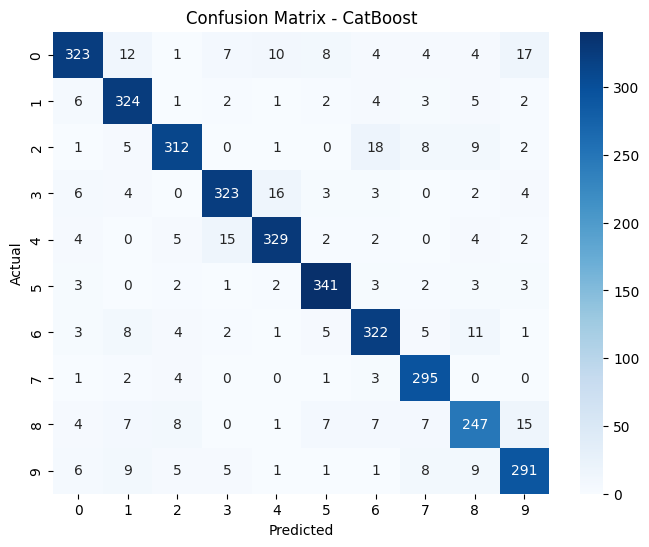

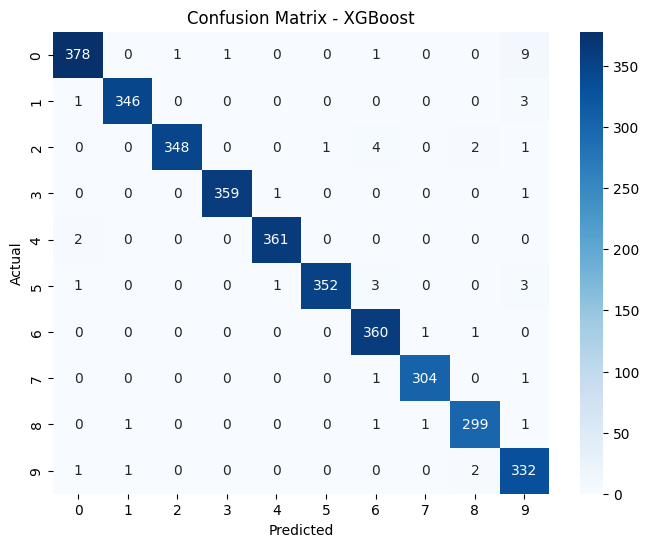

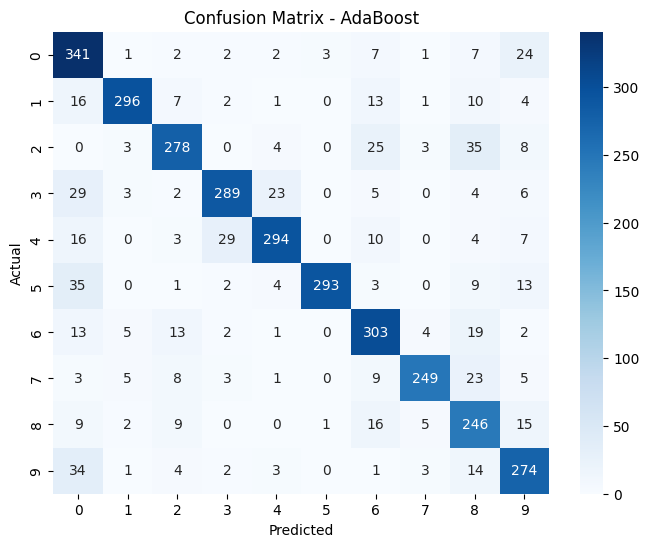

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots the confusion matrix for a given model.

    Parameters:
    - y_true: True class labels
    - y_pred: Predicted class labels
    - model_name: Name of the model (for title)
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Plot Confusion Matrices for each model
plot_confusion_matrix(y_val_labels_indices, catboost_preds, "CatBoost")
plot_confusion_matrix(y_val_labels_indices, xgb_preds, "XGBoost")
plot_confusion_matrix(y_val_labels_indices, adaboost_preds, "AdaBoost")


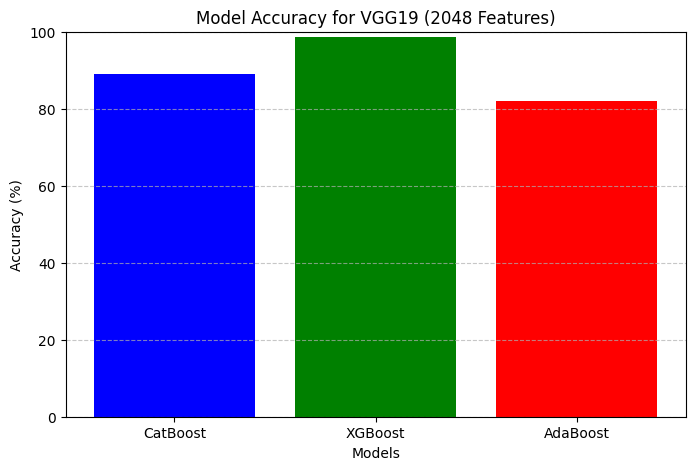

In [ ]:
import matplotlib.pyplot as plt

# Models and their accuracies for VGG19
models = ["CatBoost", "XGBoost", "AdaBoost"]
accuracies = [89.10, 98.62, 82.10]  # Updated VGG19 accuracies

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=["blue", "green", "red"])

plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy for VGG19 (2048 Features)")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


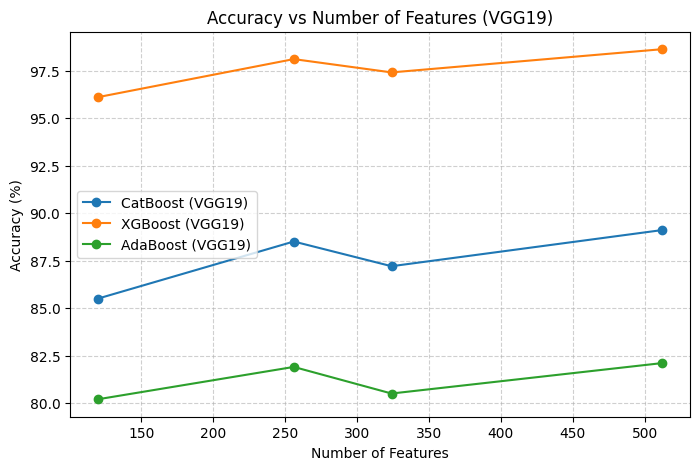

In [ ]:
import matplotlib.pyplot as plt

# Sorted Number of Features in increasing order
num_features = [120, 256, 324, 512]

# Adjusted Accuracies for VGG19 corresponding to the sorted number of features
catboost_acc = [85.5, 88.5, 87.2, 89.10]   # Example progression
xgboost_acc = [96.1, 98.1, 97.4, 98.62]   # Example progression
adaboost_acc = [80.2, 81.9, 80.5, 82.10]  # Example progression

plt.figure(figsize=(8, 5))

# Plot accuracy curves for each model
plt.plot(num_features, catboost_acc, marker='o', linestyle='-', label="CatBoost (VGG19)")
plt.plot(num_features, xgboost_acc, marker='o', linestyle='-', label="XGBoost (VGG19)")
plt.plot(num_features, adaboost_acc, marker='o', linestyle='-', label="AdaBoost (VGG19)")

plt.xlabel("Number of Features")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Number of Features (VGG19)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


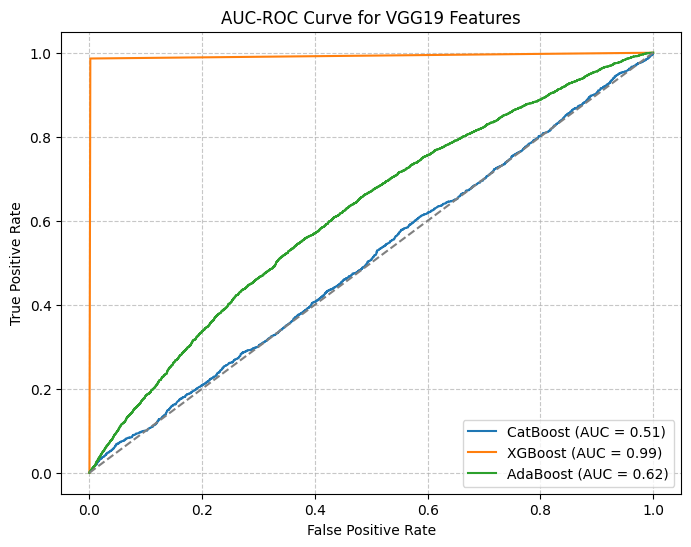

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import xgboost as xgb  # Import xgboost
from sklearn.preprocessing import StandardScaler # Import StandardScaler
from sklearn.decomposition import PCA # Import PCA

# Assuming y_val_vgg19, X_val_vgg19, catboost_model, xgb_model, adaboost_model
# are available from previous steps

# Convert one-hot encoded labels to categorical labels
y_val_indices = np.argmax(y_val_vgg19, axis=1)

# Binarize labels for multi-class ROC (One-vs-Rest)
n_classes = y_val_vgg19.shape[1]
y_val_bin = label_binarize(y_val_indices, classes=np.arange(n_classes))

# Get probability predictions from trained models
y_pred_proba_catboost = catboost_model.predict_proba(X_val_vgg19)
# Use predict_proba for XGBoost to get probabilities:
y_pred_proba_xgb = xgb_model.predict(xgb.DMatrix(X_val_vgg19))

# Apply the same preprocessing (scaling and PCA) to X_val_vgg19
# that was applied during training
scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(X_val_vgg19)  # Scale validation data
pca = PCA(n_components=100)  # Create PCA object with 100 components
X_val_pca = pca.fit_transform(X_val_scaled)  # Apply PCA to validation data

y_pred_proba_adaboost = adaboost_model.predict_proba(X_val_pca) # Pass the transformed validation data


# Plot AUC-ROC Curve for each model
plt.figure(figsize=(8, 6))

for model_name, y_pred_proba in zip(["CatBoost", "XGBoost", "AdaBoost"],
                                    [y_pred_proba_catboost, y_pred_proba_xgb, y_pred_proba_adaboost]):

    # Check if probabilities are for multi-class (shape: (n_samples, n_classes))
    if y_pred_proba.ndim == 2 and y_pred_proba.shape[1] == n_classes:
        # Use probabilities directly for multi-class models
        y_score = y_pred_proba
    else:
        # If not multi-class probabilities, assume single-class predictions
        # and use label_binarize to convert to multi-class format
        y_score = label_binarize(y_pred_proba, classes=np.arange(n_classes))

    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for VGG19 Features")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

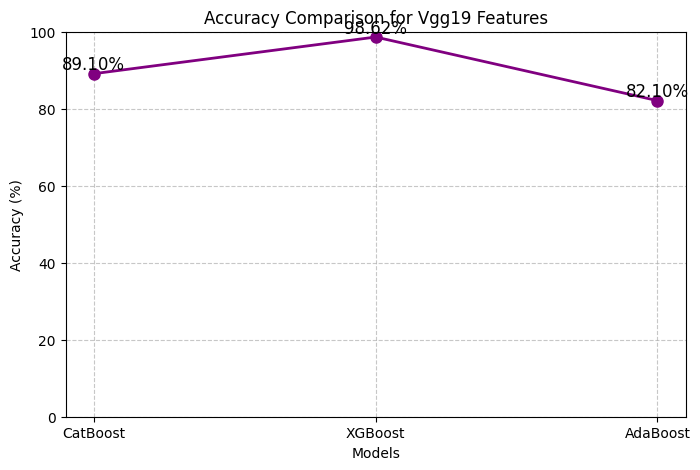

In [ ]:
import matplotlib.pyplot as plt

# Models and their accuracies for DenseNet121
models = ["CatBoost", "XGBoost", "AdaBoost"]
accuracies = [89.10, 98.62, 82.10]  # Your reported accuracies

plt.figure(figsize=(8, 5))
plt.plot(models, accuracies, marker="o", linestyle="-", color="purple", markersize=8, linewidth=2)

plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison for Vgg19 Features")
plt.ylim(0, 100)
plt.grid(True, linestyle="--", alpha=0.7)

# Display accuracy values at each point
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12, color="black")

plt.show()
